# Summary

병원 진료데이터의 기록을 바탕으로 질병을 예측, 평가.

특히 국내 사망 원인의 큰 비중을 차지하고 있는 심장병과 관련된 데이터를 바탕으로 모델을 예측한다.

> <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRVcNhoJeMapy_0AOZhDEXdipjMfrtWORcpiw&usqp=CAU" width="400px" height="300px">  
> 심장병은 암, 만성질환과 같은 악성신생물을 제외하고 가장 높은 사망 원인으로 꼽힌다.

### 진행 순서

- 1. 데이터 불러오기 (출처 명시)
    - Kaggle ~ Heart Disease UCI(https://www.kaggle.com/ronitf/heart-disease-uci)
    
- 2. 학습 모델 설정
    - XGboost, Adam 사용시의 비교 및 Ensemble을 통한 예측도 상승을 기대 
    - 1) Supervised Learning
        - Random Forest (Decision Tree Classifier)
        - SVM
        - Knn
    - 2) ~~Unsupervised Learning~~
        - ~~K-Means~~
    - 3) Using Neural Networks
        - RNN
    
- 3. 예측/평가
    - Confusion Matrix
    - F1-score
    - k-fold cross validation
    
~~- 4. 추가 과제~~  
    ~~- 앙상블 사용 시 hard voting이 아닌, 한 파이프라인 안에서 진행될 수 있도록 진행~~

# 1. Load Modules and Dataset

In [60]:
# common library for DataFrame
import numpy as np
import pandas as pd
import warnings # suppress matplotlib warning
warnings.filterwarnings('ignore') 

# Visualization & plotting
from sklearn.metrics import plot_precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt

# for data split and training
from sklearn.model_selection import train_test_split

# for the modelling
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier # Knn

# for building and training Neural Networks
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout # normalization
from keras import regularizers

# for evaluation
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, classification_report
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [4]:
import sys
import pandas
import numpy
import keras
import sklearn
import matplotlib

print('Python: {}'.format(sys.version))
print('Pandas: {}'.format(pd.__version__))
print('Numpy: {}'.format(np.__version__))
print('Sklearn: {}'.format(sklearn.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Keras: {}'.format(keras.__version__))

Python: 3.7.3 (v3.7.3:ef4ec6ed12, Mar 25 2019, 22:22:05) [MSC v.1916 64 bit (AMD64)]
Pandas: 0.25.3
Numpy: 1.16.4
Sklearn: 0.22.1
Matplotlib: 3.3.1
Keras: 2.3.1


In [5]:
df = pd.read_csv('./dataset/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [6]:
df.shape

(303, 14)

In [7]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [8]:
print(f'Index: {df.index}')
print(f'Columns: {df.shape[1]}')

Index: RangeIndex(start=0, stop=303, step=1)
Columns: 14


## Data Description

> - 1. age : age in years
> - 2. sex : (1 = male; 0 = female)
> - 3. cp : chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 4 = asymptomatic)
> - 4. trestbps : resting blood pressure (in mm Hg on admission to the hospital)
> - 5. chol : serum cholestorla in mg/dl
> - 6. fbs : (fasting blood sugar & gt; 120mg/dl) (1 = true; 0 = false)
> - 7. restecg : resting electrocardiographic results
> - 8. thalach : maximum heart rate achieved
> - 9. exang : exercise induced angina (1 = yes; 0 = no)
> - 10. oldpeak :ST depression induced by exercise relative to rest
> - 11. slope : the slope of the peak exercise ST segment
> - 12. ca : number of major vessels (0-3) colored by flourosopy
> - 13. thal : 3 = normal; 6 = fixed defect; 7 = reversable defect
> - 14. target : 1 or 0

### Data Cleansing
##### remove NaN or missing data(indicated with a '?')

In [9]:
data = df[~df.isin(['?'])]
data = data.dropna(axis=0)

In [10]:
import pandas_profiling
profile = pandas_profiling.ProfileReport(data)
profile

# Create Training and Testing Dataset

In [11]:
# 1) Target value split
# `y` is result, `x` is factors of y (in views of logistic function)
Y = data.target.values
X_data = data.drop(['target'], axis=1)

In [12]:
# 2) minMAX-Normalization & Standardization

# minMAX-Normalization(Scale a variable to have a values between 0 and 1)
X_norm = (X_data - np.min(X_data)) / (np.max(X_data) - np.min(X_data))

# Standardization(Transforms data to have a mean of zero and std of 1)
x_mean = X_data.mean(axis=0)
X_std = X_data - x_mean
std = X_data.std(axis=0)
X_std /= std

In [13]:
X_norm

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,0.708333,1.0,1.000000,0.481132,0.244292,1.0,0.0,0.603053,0.0,0.370968,0.0,0.00,0.333333
1,0.166667,1.0,0.666667,0.339623,0.283105,0.0,0.5,0.885496,0.0,0.564516,0.0,0.00,0.666667
2,0.250000,0.0,0.333333,0.339623,0.178082,0.0,0.0,0.770992,0.0,0.225806,1.0,0.00,0.666667
3,0.562500,1.0,0.333333,0.245283,0.251142,0.0,0.5,0.816794,0.0,0.129032,1.0,0.00,0.666667
4,0.583333,0.0,0.000000,0.245283,0.520548,0.0,0.5,0.702290,1.0,0.096774,1.0,0.00,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,0.583333,0.0,0.000000,0.433962,0.262557,0.0,0.5,0.396947,1.0,0.032258,0.5,0.00,1.000000
299,0.333333,1.0,1.000000,0.150943,0.315068,0.0,0.5,0.465649,0.0,0.193548,0.5,0.00,1.000000
300,0.812500,1.0,0.000000,0.471698,0.152968,1.0,0.5,0.534351,0.0,0.548387,0.5,0.50,1.000000
301,0.583333,1.0,0.000000,0.339623,0.011416,0.0,0.5,0.335878,1.0,0.193548,0.5,0.25,1.000000


In [14]:
X_std

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,0.950624,0.679881,1.969864,0.762694,-0.255910,2.390484,-1.004171,0.015417,-0.69548,1.085542,-2.270822,-0.713249,-2.145324
1,-1.912150,0.679881,1.000921,-0.092585,0.072080,-0.416945,0.897478,1.630774,-0.69548,2.119067,-2.270822,-0.713249,-0.512075
2,-1.471723,-1.465992,0.031978,-0.092585,-0.815424,-0.416945,-1.004171,0.975900,-0.69548,0.310399,0.974740,-0.713249,-0.512075
3,0.179877,0.679881,0.031978,-0.662770,-0.198030,-0.416945,0.897478,1.237849,-0.69548,-0.206364,0.974740,-0.713249,-0.512075
4,0.289984,-1.465992,-0.936965,-0.662770,2.078611,-0.416945,0.897478,0.582975,1.43311,-0.378618,0.974740,-0.713249,-0.512075
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,0.289984,-1.465992,-0.936965,0.477601,-0.101562,-0.416945,0.897478,-1.163356,1.43311,-0.723126,-0.648041,-0.713249,1.121174
299,-1.031296,0.679881,1.969864,-1.232956,0.342190,-0.416945,0.897478,-0.770432,-0.69548,0.138144,-0.648041,-0.713249,1.121174
300,1.501157,0.679881,-0.936965,0.705675,-1.027653,2.390484,0.897478,-0.377507,-0.69548,2.032940,-0.648041,1.242538,1.121174
301,0.289984,0.679881,-0.936965,-0.092585,-2.223854,-0.416945,0.897478,-1.512623,1.43311,0.138144,-0.648041,0.264644,1.121174


# 3) Train_test split
# train_test data split | train: 0.8; test: 0.2;

In [15]:
# first : use normalized data | second: use stdardized data

X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y, test_size=0.2, random_state = 0)
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X_std, Y, test_size=0.2, random_state = 0)

In [16]:
from keras.utils.np_utils import to_categorical
Y_train_category = to_categorical(Y_train, num_classes=None)
Y_test_category = to_categorical(Y_test, num_classes=None)

print(Y_train.shape, Y_test.shape)
print(Y_train_category.shape, Y_test_category.shape)

(242,) (61,)
(242, 2) (61, 2)


In [ ]:
from keras.utils.np_utils import to_categorical
Y_train = to_categorical(Y_train, num_classes=None)
Y_test = to_categorical(Y_test, num_classes=None)

# print(Y_train.shape, Y_test.shape)
# print(Y_train_category.shape, Y_test_category.shape)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from keras import regularizers

# define a function to build the keras model
def create_model(last_active_func, loss_func, opti, output_node):
    # create model
    model = Sequential()
    model.add(Dense(16, input_dim=13, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(8, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(output_node, activation=last_active_func)) 

    # compile model
    adam = Adam(lr=0.001)
    model.compile(loss=loss_func, optimizer=opti, metrics=['accuracy'])
    return model

categorical_model = create_model(last_active_func ='softmax', loss_func='categorical_crossentropy', opti='rmsprop', output_node=2)
binary_model = create_model(last_active_func='sigmoid', loss_func='binary_crossentropy', opti='adam', output_node=1)

print(categorical_model.summary())
print(binary_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                224       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 18        
Total params: 378
Trainable params: 378
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Ou

In [18]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
print(Y_train_category.shape, Y_test_category.shape)

(242, 13) (61, 13) (242,) (61,)
(242, 2) (61, 2)


In [19]:
# fit the model to the training data
hist = categorical_model.fit(X_train, Y_train_category, epochs=50, batch_size=10, validation_data=(X_test, Y_test_category))

Epoch 1/50
25/25 [==============================] - 0s 11ms/step - loss: 0.6921 - accuracy: 0.5413 - val_loss: 0.6881 - val_accuracy: 0.5574
Epoch 2/50
25/25 [==============================] - 0s 2ms/step - loss: 0.6858 - accuracy: 0.5413 - val_loss: 0.6794 - val_accuracy: 0.5574
Epoch 3/50
25/25 [==============================] - 0s 2ms/step - loss: 0.6756 - accuracy: 0.5455 - val_loss: 0.6658 - val_accuracy: 0.5574
Epoch 4/50
25/25 [==============================] - 0s 3ms/step - loss: 0.6605 - accuracy: 0.5909 - val_loss: 0.6495 - val_accuracy: 0.7541
Epoch 5/50
25/25 [==============================] - 0s 2ms/step - loss: 0.6494 - accuracy: 0.6777 - val_loss: 0.6329 - val_accuracy: 0.7541
Epoch 6/50
25/25 [==============================] - 0s 2ms/step - loss: 0.6288 - accuracy: 0.7025 - val_loss: 0.6107 - val_accuracy: 0.7541
Epoch 7/50
25/25 [==============================] - 0s 2ms/step - loss: 0.6084 - accuracy: 0.7438 - val_loss: 0.5915 - val_accuracy: 0.8197
Epoch 8/50
25/25 [=

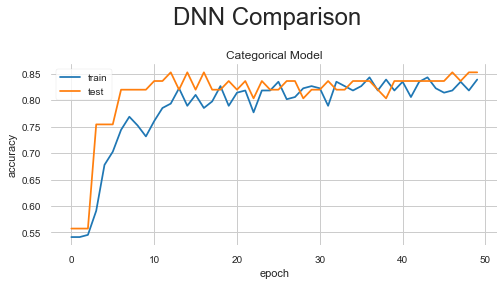

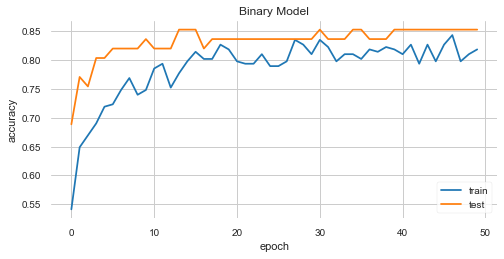

In [85]:
%matplotlib inline

plt.figure(figsize=(8,8))
plt.suptitle('DNN Comparison', fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(2,1,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Categorical Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

plt.figure(figsize=(8,8))
plt.subplot(2,1,2)
plt.plot(binary_hist.history['accuracy'])
plt.plot(binary_hist.history['val_accuracy'])
plt.title('Binary Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# sns.heatmap(confusion_matrices[name],annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

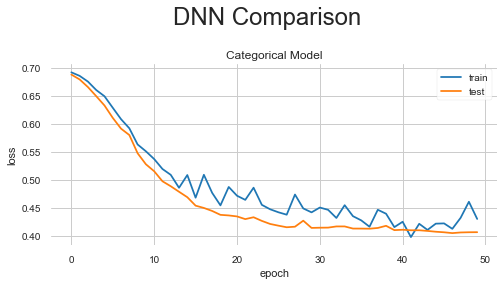

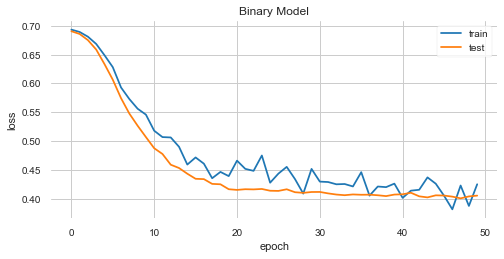

In [86]:
%matplotlib inline

plt.figure(figsize=(8,8))
plt.suptitle('DNN Comparison', fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(2,1,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Categorical Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

plt.figure(figsize=(8,8))
plt.subplot(2,1,2)
plt.plot(binary_hist.history['loss'])
plt.plot(binary_hist.history['val_loss'])
plt.title('Binary Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# sns.heatmap(confusion_matrices[name],annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

In [24]:
binary_hist = binary_model.fit(X_train, Y_train, epochs=50, batch_size=10, validation_data=(X_test, Y_test))

Epoch 1/50
25/25 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.5413 - val_loss: 0.6904 - val_accuracy: 0.6885
Epoch 2/50
25/25 [==============================] - 0s 2ms/step - loss: 0.6891 - accuracy: 0.6488 - val_loss: 0.6856 - val_accuracy: 0.7705
Epoch 3/50
25/25 [==============================] - 0s 2ms/step - loss: 0.6809 - accuracy: 0.6694 - val_loss: 0.6749 - val_accuracy: 0.7541
Epoch 4/50
25/25 [==============================] - 0s 3ms/step - loss: 0.6683 - accuracy: 0.6901 - val_loss: 0.6586 - val_accuracy: 0.8033
Epoch 5/50
25/25 [==============================] - 0s 2ms/step - loss: 0.6488 - accuracy: 0.7190 - val_loss: 0.6333 - val_accuracy: 0.8033
Epoch 6/50
25/25 [==============================] - 0s 2ms/step - loss: 0.6281 - accuracy: 0.7231 - val_loss: 0.6063 - val_accuracy: 0.8197
Epoch 7/50
25/25 [==============================] - 0s 2ms/step - loss: 0.5927 - accuracy: 0.7479 - val_loss: 0.5741 - val_accuracy: 0.8197
Epoch 8/50
25/25 [==

In [117]:
binary_pred = binary_model.predict(X_test)
categorical_pred = categorical_model.predict(X_test)

rounded_binary = np.round(binary_pred.reshape(1, 61)[0]).astype(int)
rounded_category = np.round(categorical_pred.reshape(2, 61)[0]).astype(int)

print('classification report\n\n')
print(f'Binary Model:\n',classification_report(Y_test,rounded_binary))
print('----'*20)
print(f'Categorical Model:\n',classification_report(Y_test,rounded_category))

classification report


Binary Model:
               precision    recall  f1-score   support

           0       0.88      0.78      0.82        27
           1       0.84      0.91      0.87        34

    accuracy                           0.85        61
   macro avg       0.86      0.84      0.85        61
weighted avg       0.85      0.85      0.85        61

--------------------------------------------------------------------------------
Categorical Model:
               precision    recall  f1-score   support

           0       0.39      0.44      0.41        27
           1       0.50      0.44      0.47        34

    accuracy                           0.44        61
   macro avg       0.44      0.44      0.44        61
weighted avg       0.45      0.44      0.44        61



In [112]:
Y_test_category

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.

In [113]:
categorical_pred

array([[0.8749238 , 0.12507619],
       [0.13735478, 0.8626452 ],
       [0.12518589, 0.8748141 ],
       [0.88637453, 0.11362541],
       [0.83505   , 0.16494998],
       [0.5749724 , 0.42502764],
       [0.82708144, 0.17291857],
       [0.80592597, 0.19407403],
       [0.9275351 , 0.07246489],
       [0.9284116 , 0.07158848],
       [0.14023678, 0.8597632 ],
       [0.08696481, 0.9130352 ],
       [0.8500134 , 0.14998655],
       [0.14236148, 0.85763854],
       [0.07161891, 0.9283811 ],
       [0.39929911, 0.60070086],
       [0.84373975, 0.15626025],
       [0.22605518, 0.7739448 ],
       [0.9136605 , 0.0863395 ],
       [0.15385132, 0.84614867],
       [0.18162626, 0.81837374],
       [0.6708763 , 0.32912368],
       [0.7895817 , 0.21041825],
       [0.82373714, 0.17626281],
       [0.14307408, 0.8569259 ],
       [0.25732973, 0.7426703 ],
       [0.78888273, 0.21111731],
       [0.5049858 , 0.49501425],
       [0.06310371, 0.9368963 ],
       [0.35096732, 0.6490328 ],
       [0.

In [109]:
rounded_binary = np.round(binary_pred.reshape(1, 61)[0]).astype(int)
print(f'Binary Model:\n',classification_report(Y_test,rounded_binary))

Binary Model:
               precision    recall  f1-score   support

           0       0.88      0.78      0.82        27
           1       0.84      0.91      0.87        34

    accuracy                           0.85        61
   macro avg       0.86      0.84      0.85        61
weighted avg       0.85      0.85      0.85        61



In [47]:
classifiers = [
    SVC(kernel="linear", C=0.025), # Linear SVM
    SVC(gamma=2, C=1), # Non-Linear SVM
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=8, max_features=1),
    KNeighborsClassifier(n_neighbors=2)
]

model_names = [
    'Linear_SVM',
    'Nonlinear_SVM',
    'Decision_Tree',
    'Random_Forest',
    'KNN',
]

accuracies = {}
for i in range(len(model_names)):
    model_name = model_names[i]
    cur_clf = classifiers[i]
    
    if model_name == 'KNN':
        tmp_model = cur_clf.fit(X_train, Y_train)
        acc = tmp_model.score(X_test, Y_test)
    else:
        tmp_model = cur_clf.fit(X_train2, Y_train2)
        acc = tmp_model.score(X_test2, Y_test2)
    accuracies[model_name] = acc
    print(f'{model_name} Test Accuracy: {acc:.3f}')

Linear_SVM Test Accuracy: 0.836
Nonlinear_SVM Test Accuracy: 0.574
Decision_Tree Test Accuracy: 0.754
Random_Forest Test Accuracy: 0.885
KNN Test Accuracy: 0.836


In [48]:
print(tmp_model.score(X_test2,Y_test2))

0.8032786885245902


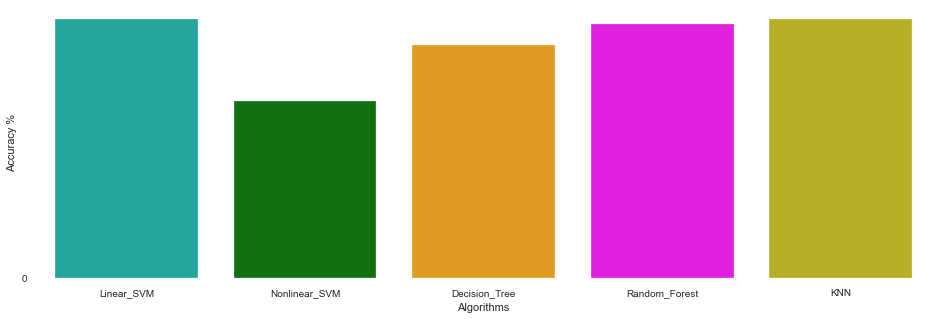

In [42]:
colors = ["#0FBBAE", "green", "orange", "magenta","#CFC60E"]

sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Accuracy %")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()

In [128]:
classifiers = [
    SVC(kernel="linear", C=0.025), # Linear SVM
    SVC(gamma=2, C=1), # Non-Linear SVM
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=8, max_features=1),
    KNeighborsClassifier(n_neighbors=2)
]

model_names = [
    'Linear_SVM',
    'Nonlinear_SVM',
    'Decision_Tree',
    'Random_Forest',
    'KNN',
]

accuracies = {}
predicts = {}
confusion_matrices = {}
model_dict = {}

print('classification reports\n\n')
for i in range(len(model_names)):
    model_name = model_names[i]
    cur_clf = classifiers[i]
    
    if model_name == 'KNN':
        tr_Y = Y_train
        tr_X = X_train
        te_Y = Y_test
        te_X = X_test
    
    else:
        tr_Y = Y_train2
        tr_X = X_train2
        te_Y = Y_test2
        te_X = X_test2
        
    tmp_model = cur_clf.fit(tr_X, tr_Y)
    model_dict[model_name] = tmp_model
    
    acc = tmp_model.score(te_X, te_Y)    
    accuracies[model_name] = acc
    tmp_pred = tmp_model.predict(te_X)
    predicts[model_name] = tmp_pred
    confusion_matrices[model_name] = confusion_matrix(te_Y, tmp_pred)
    print(f'{model_name}:\n',classification_report(te_Y,tmp_pred))
    print('----'*20)

classification reports


Linear_SVM:
               precision    recall  f1-score   support

           0       0.90      0.70      0.79        27
           1       0.80      0.94      0.86        34

    accuracy                           0.84        61
   macro avg       0.85      0.82      0.83        61
weighted avg       0.85      0.84      0.83        61

--------------------------------------------------------------------------------
Nonlinear_SVM:
               precision    recall  f1-score   support

           0       1.00      0.04      0.07        27
           1       0.57      1.00      0.72        34

    accuracy                           0.57        61
   macro avg       0.78      0.52      0.40        61
weighted avg       0.76      0.57      0.43        61

--------------------------------------------------------------------------------
Decision_Tree:
               precision    recall  f1-score   support

           0       0.72      0.78      0.75        27
     

In [52]:
from pprint import pprint as pp
pp(confusion_matrices)

{'Decision_Tree': array([[21,  6],
       [ 8, 26]], dtype=int64),
 'KNN': array([[25,  2],
       [ 8, 26]], dtype=int64),
 'Linear_SVM': array([[19,  8],
       [ 2, 32]], dtype=int64),
 'Nonlinear_SVM': array([[ 1, 26],
       [ 0, 34]], dtype=int64),
 'Random_Forest': array([[23,  4],
       [ 6, 28]], dtype=int64)}


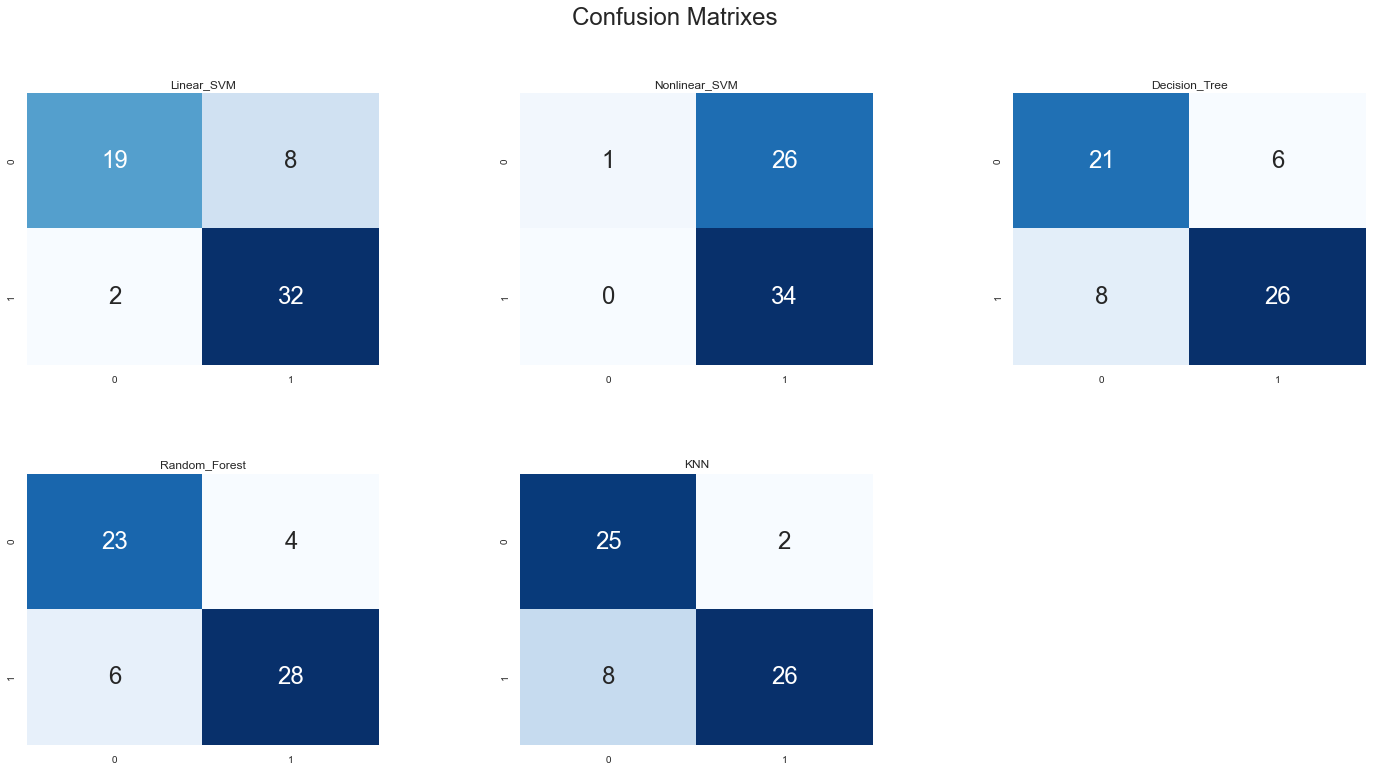

In [59]:
plt.figure(figsize=(24,12))

plt.suptitle('Confusion Matrixes', fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

for idx, name in enumerate(confusion_matrices):
    plt.subplot(2,3,idx+1)
    plt.title(name)
    sns.heatmap(confusion_matrices[name],annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
    
plt.show()

In [ ]:
from sklearn.metrics import recall_score

In [ ]:
model_clf_dict['KNN'].fit(X_train, Y_train)

In [ ]:
prediction = model_clf_dict['KNN'].predict(X_test)

print(f" NN score : {model_clf_dict['KNN'].score(X_test, Y_test)*100}")

In [ ]:
estimator = model.estimators_[1]
feature_names = [i for i in X_train.columns]

Y_train_str = Y_train.astype('str')
Y_train_str[Y_train_str == '0'] = 'no disease'
Y_train_str[Y_train_str == '1'] = 'disease'
Y_train_str = Y_train_str.values

In [ ]:
from sklearn.tree import export_graphviz # plot tree

In [ ]:
# 나이에 따른 심장병 발병빈도
pd.crosstab(data.age, data.target).plot(kind='bar', figsize=(30, 8))
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

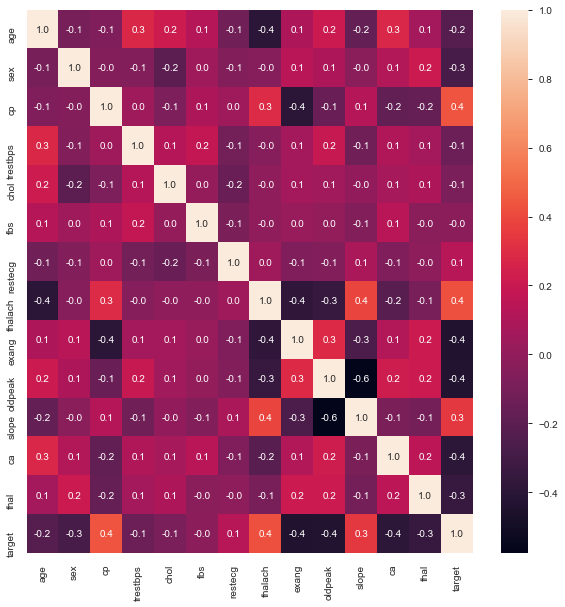

In [30]:
# 상관계수 히트맵
plt.figure(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, fmt='.1f')
plt.show()

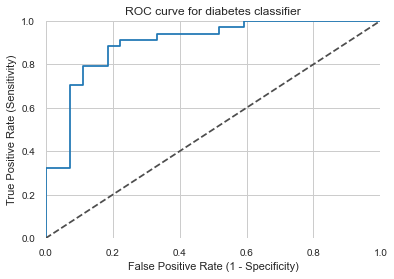

In [120]:
fpr, tpr, thresholds = roc_curve(Y_test, binary_pred)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [123]:
auc(fpr, tpr)

0.8965141612200436

In [125]:
import eli5
from eli5.sklearn import PermutationImportance
import shap
from pdpbox import pdp, info_plots

In [134]:
perm = PermutationImportance(model_dict['Linear_SVM'], random_state=1).fit(X_test2, Y_test2)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0787 ± 0.0730,cp
0.0262 ± 0.0393,thal
0.0098 ± 0.0572,oldpeak
0.0098 ± 0.0161,restecg
0.0066 ± 0.0262,slope
0.0066 ± 0.0334,thalach
0.0066 ± 0.0262,sex
0.0066 ± 0.0161,chol
0.0033 ± 0.0245,exang
0 ± 0.0000,fbs


In [135]:
perm = PermutationImportance(model_dict['Nonlinear_SVM'], random_state=1).fit(X_test2, Y_test2)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0197 ± 0.0131,cp
0.0197 ± 0.0245,thal
0.0197 ± 0.0382,ca
0.0164 ± 0.0000,chol
0.0131 ± 0.0131,exang
0.0131 ± 0.0131,thalach
0.0098 ± 0.0161,slope
0.0098 ± 0.0161,oldpeak
0.0066 ± 0.0161,fbs
0.0066 ± 0.0161,trestbps


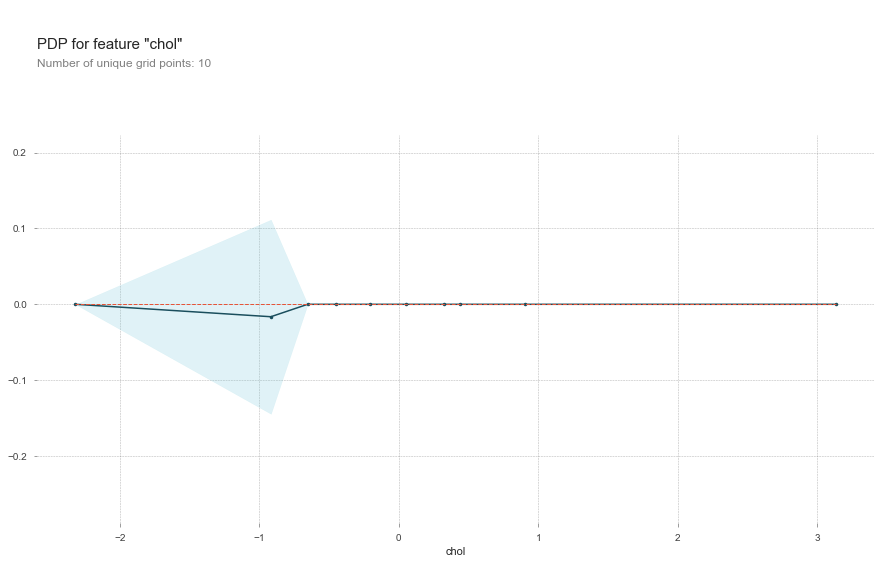

In [161]:
base_features = df.columns.values.tolist()
base_features.remove('target')

feat_name = 'chol'
pdp_dist = pdp.pdp_isolate(model=model_dict['Nonlinear_SVM'], dataset= X_test2, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

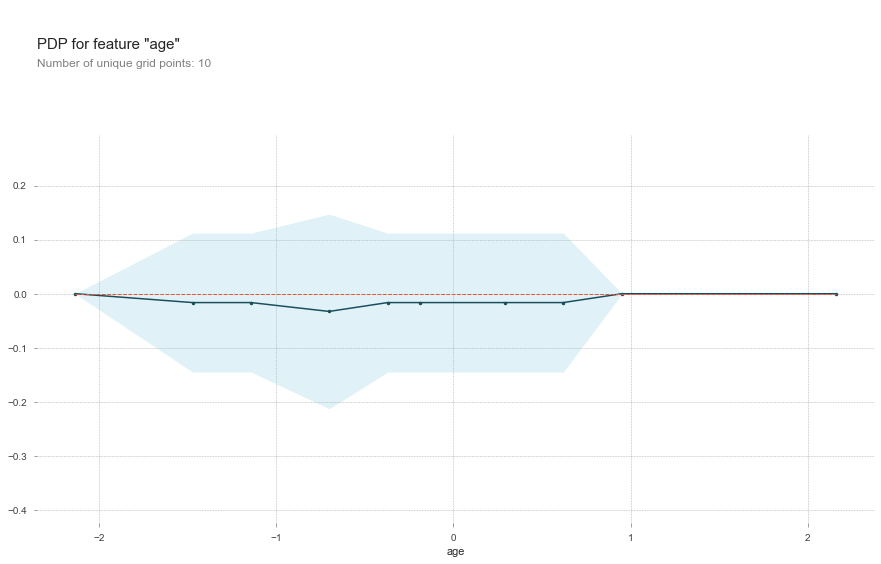

In [162]:
base_features = df.columns.values.tolist()
base_features.remove('target')

feat_name = 'age'
pdp_dist = pdp.pdp_isolate(model=model_dict['Nonlinear_SVM'], dataset= X_test2, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

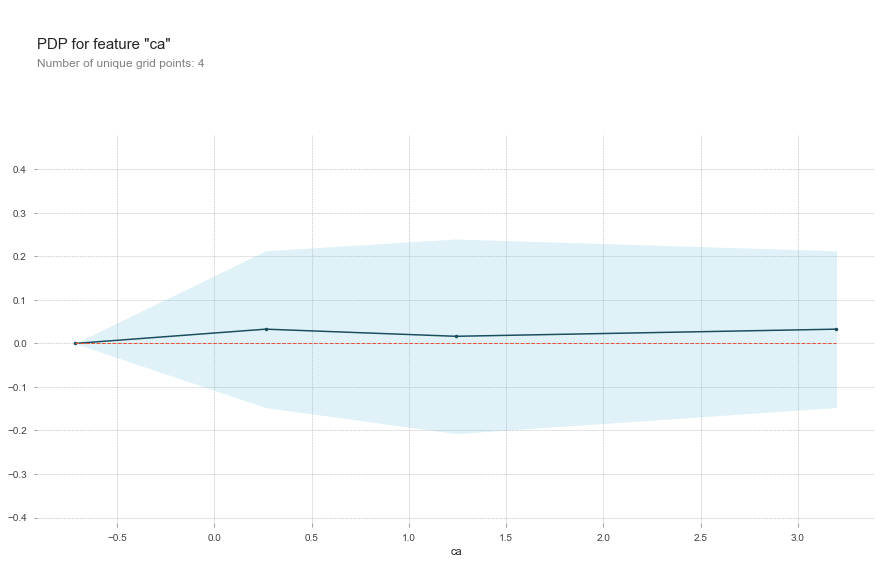

In [164]:
base_features = df.columns.values.tolist()
base_features.remove('target')

feat_name = 'ca'
pdp_dist = pdp.pdp_isolate(model=model_dict['Nonlinear_SVM'], dataset= X_test2, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

In [129]:
from pprint import pprint as pp
pp(model_dict)

{'Decision_Tree': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'),
 'KNN': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform'),
 'Linear_SVM': SVC(C=0.025, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False),
 'Nonlinear_SVM': SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,

In [146]:
model_dict

{'Linear_SVM': SVC(C=0.025, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False),
 'Nonlinear_SVM': SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf', max_iter=-1,
     probability=False, random_state=None, shrinking=True, tol=0.001,
     verbose=False),
 'Decision_Tree': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=5, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'),
 'Random_Fores

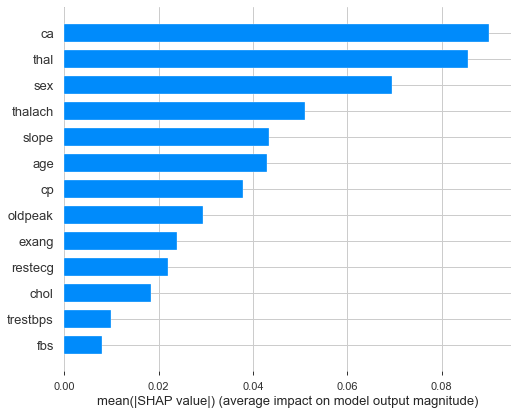

In [159]:
model_name = 'Random_Forest'

explainer = shap.TreeExplainer(model_dict[model_name])
shap_values = explainer.shap_values(X_test2)

shap.summary_plot(shap_values[1], X_test2, plot_type="bar")

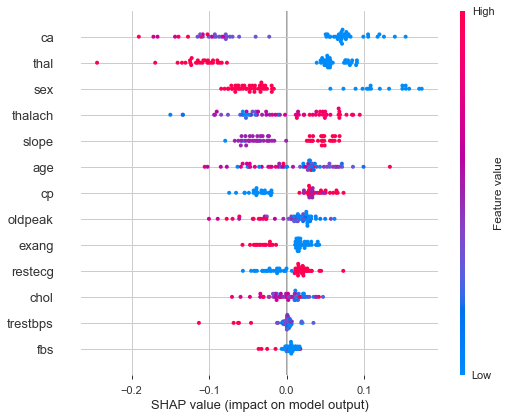

In [160]:
shap.summary_plot(shap_values[1], X_test2)

In [153]:
model_dict[nl_SVM]

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [154]:
predicts[nl_SVM]

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [149]:
print(shap.GradientExplainer.__doc__)

 Explains a model using expected gradients (an extension of integrated gradients).

    Expected gradients an extension of the integrated gradients method (Sundararajan et al. 2017), a
    feature attribution method designed for differentiable models based on an extension of Shapley
    values to infinite player games (Aumann-Shapley values). Integrated gradients values are a bit
    different from SHAP values, and require a single reference value to integrate from. As an adaptation
    to make them approximate SHAP values, expected gradients reformulates the integral as an expectation
    and combines that expectation with sampling reference values from the background dataset. This leads
    to a single combined expectation of gradients that converges to attributions that sum to the
    difference between the expected model output and the current output.
    


In [150]:
pp(predicts)

{'Decision_Tree': array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1], dtype=int64),
 'KNN': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1], dtype=int64),
 'Linear_SVM': array([0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1], dtype=int64),
 'Nonlinear_SVM': array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64),
 'Random_Forest': array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1